In [3]:
import cv2
import sys
import itertools
import os,shutil
from cvloop import cvloop
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import face_recognition
import multiprocessing as mp

from functools import partial
from keras.models import load_model,Sequential
from keras.preprocessing.image import load_img,img_to_array,ImageDataGenerator
from keras.layers import Dense,Conv2D,MaxPooling2D,Flatten,Dropout
from keras.callbacks import TensorBoard
from sklearn.metrics import classification_report,confusion_matrix

Using TensorFlow backend.


# Preparing Data

In [6]:
def get_face(frame):
    scaling_factor=1
    downscaled_frame=cv2.resize(frame,(0,0),fx=scaling_factor,fy=scaling_factor)
    face_locations = face_recognition.face_locations(downscaled_frame)    
    for face_location in face_locations:
        t,r,b,l = list(map(lambda x: int(x/scaling_factor), face_location))
        face_image=cv2.resize(frame[t:b, l:r],(150,150))
    return face_image

def image_from_landmarks(frame):
    face_landmarks = face_recognition.face_landmarks(frame)   
    image = np.zeros(frame.shape[:2])
    for i in face_landmarks:
        for j in list(i.values()):
            pts = np.array(j, np.int32)
            image = cv2.polylines(image, [pts], False, (255,255,255), 2)
    return image

def data_generator(path_output_dir,img_path):
    global count
    frame=cv2.imread(img_path)
    frame=get_face(frame)    
    image=image_from_landmarks(frame)
            
    cv2.imwrite(os.path.join(path_output_dir, '%d.png') % count, image)
    count += 1

In [ ]:
count=0
base_path='/home/ubuntu/videos/ck_dataset/testing/4/'
output_path='/home/ubuntu/videos/ck_landmarks_dataset/testing/4'
var_xyz=[data_generator(output_path,base_path+img_path)  for img_path in os.listdir(base_path)]

# Building ntw and Model Training

In [3]:
train_data_gen=ImageDataGenerator(rescale=1./255,
                                  rotation_range=40,
                                  width_shift_range=0.2 ,
                                  height_shift_range=0.2,
                                  shear_range=0.2, 
                                  zoom_range=0.2,
                                  horizontal_flip=True,
                                  fill_mode='nearest'
                             )

val_data_gen=ImageDataGenerator(rescale=1./255)

In [4]:
train_dir='/home/ubuntu/videos/ck_landmarks_dataset/training/'
val_dir='/home/ubuntu/videos/ck_landmarks_dataset/testing/'

In [5]:
train_gen=train_data_gen.flow_from_directory(train_dir,target_size=(150,150),batch_size=64,class_mode='categorical',color_mode="grayscale")
val_gen=val_data_gen.flow_from_directory(val_dir,target_size=(150,150),batch_size=64,class_mode='categorical',color_mode="grayscale")

Found 1065 images belonging to 7 classes.
Found 118 images belonging to 7 classes.


# Network

In [6]:
model = Sequential()
model.add(Conv2D(16, (3, 3), activation='relu',
                        input_shape=(150,150,1)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(7, activation='softmax'))

W0807 12:53:00.257716 140352884799232 deprecation_wrapper.py:119] From /home/ubuntu/anaconda3/envs/video_env/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0807 12:53:00.277014 140352884799232 deprecation_wrapper.py:119] From /home/ubuntu/anaconda3/envs/video_env/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0807 12:53:00.281220 140352884799232 deprecation_wrapper.py:119] From /home/ubuntu/anaconda3/envs/video_env/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0807 12:53:00.299407 140352884799232 deprecation_wrapper.py:119] From /home/ubuntu/anaconda3/envs/video_env/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool 

In [7]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 16)      160       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 32)        4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 17, 17, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 15, 15, 128)       73856     
__________

In [8]:
model.compile(optimizer='adadelta',loss='categorical_crossentropy',metrics=['accuracy'])

W0807 12:53:00.628703 140352884799232 deprecation_wrapper.py:119] From /home/ubuntu/anaconda3/envs/video_env/lib/python3.7/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0807 12:53:00.648617 140352884799232 deprecation_wrapper.py:119] From /home/ubuntu/anaconda3/envs/video_env/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3295: The name tf.log is deprecated. Please use tf.math.log instead.



In [ ]:
history = model.fit_generator(train_gen,
                              steps_per_epoch=25,
                              epochs=150,
                              validation_data=val_gen,
                              validation_steps=50,
                              callbacks= [TensorBoard()]
                             )

In [ ]:
plt.plot(model.history.history.get('acc'))
plt.plot(model.history.history.get('val_acc'))
plt.legend(["acc","val_acc"])

In [ ]:
model.save('landmarks_based_FER_model1.h5')

# Testing

In [4]:
model=load_model('/home/ubuntu/sourav_kamboj/models/landmarks_based_FER_model1.h5')

W1031 06:33:54.766525 140586237437696 deprecation_wrapper.py:119] From /home/ubuntu/anaconda3/envs/video_env/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1031 06:33:54.785739 140586237437696 deprecation_wrapper.py:119] From /home/ubuntu/anaconda3/envs/video_env/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W1031 06:33:54.802565 140586237437696 deprecation_wrapper.py:119] From /home/ubuntu/anaconda3/envs/video_env/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W1031 06:33:54.869646 140586237437696 deprecation_wrapper.py:119] From /home/ubuntu/anaconda3/envs/video_env/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:131: The name tf.get_default_graph is deprecated

In [5]:
emotion_list_dic={0:'Angry',1:'Disgust',2:'Fear',3:'Happy',4:'Sad',5:'Surprised',6:'Neutral'}

In [9]:
test_data_gen=ImageDataGenerator(rescale=1./255)
test_dir='/home/ubuntu/sourav_kamboj/data/datasets/ck_landmarks_dataset/testing/'

In [10]:
# Make sure you use ***** shuffle=False ***** in your test generator
# and reset it using validation_generator.reset() before you make your predictions.
test_gen=test_data_gen.flow_from_directory(test_dir,target_size=(150,150),batch_size=64,class_mode='categorical',color_mode="grayscale",shuffle=False)

Found 118 images belonging to 7 classes.


In [11]:
test_gen.reset()

In [12]:
actual_labels=test_gen.classes
actual_labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6], dtype=int32)

In [13]:
nb_samples = len(test_gen.filenames) 
nb_samples

118

In [14]:
preds=model.predict_generator(test_gen,steps=nb_samples/64)  #steps=total_sample/batch_size
len(preds)

118

In [15]:
pred_labels=[pred.argmax() for pred in preds] 
print(pred_labels)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 6, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 6, 4, 6, 6, 4, 4, 6, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 0, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 4]


In [16]:
print("classification report: ")
print(classification_report(actual_labels,pred_labels))

classification report: 
              precision    recall  f1-score   support

           0       0.83      0.88      0.86        17
           1       0.86      0.86      0.86        14
           2       1.00      1.00      1.00        10
           3       1.00      0.95      0.98        21
           4       0.83      0.56      0.67         9
           5       1.00      1.00      1.00        22
           6       0.82      0.92      0.87        25

    accuracy                           0.91       118
   macro avg       0.91      0.88      0.89       118
weighted avg       0.91      0.91      0.90       118



In [17]:
print("confusion matrix: ")
print(confusion_matrix(actual_labels,pred_labels))

confusion matrix: 
[[15  2  0  0  0  0  0]
 [ 2 12  0  0  0  0  0]
 [ 0  0 10  0  0  0  0]
 [ 0  0  0 20  0  0  1]
 [ 0  0  0  0  5  0  4]
 [ 0  0  0  0  0 22  0]
 [ 1  0  0  0  1  0 23]]


In [18]:
def emotion_detection(frame):
    global i
    scaling_factor=0.25
    downscaled_frame=cv2.resize(frame,(0,0),fx=scaling_factor,fy=scaling_factor)
    face_locations = face_recognition.face_locations(downscaled_frame)    
    for face_location in face_locations:
        t,r,b,l = list(map(lambda x: int(x/scaling_factor), face_location))
        frame = cv2.rectangle(frame, (l, t), (r, b), (0,0,255), 2)
        cv2.putText(frame, pred_emotions[i], (l, t), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), lineType=cv2.LINE_AA, thickness=2)
        #if i>=(len(emotion_obj)-1):
            #cv2.putText(frame, avg_emotions[i-(len(emotion_obj)-1)], (l, t), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), lineType=cv2.LINE_AA, thickness=2)
        i += 1
    return frame


def video_with_predicted_emotions(path):   
    scaling_factor=0.25
    cap = cv2.VideoCapture(path)
    fourcc = cv2.VideoWriter_fourcc(*'MP4V')                        #before writing a new video make sure (width,height)  is updated
    out = cv2.VideoWriter('emotion_analysis_Larren.avi',fourcc, 20.0, (1280,720))
    i=0
    while(cap.isOpened()):
        ret, frame = cap.read()
        if ret==True:
            downscaled_frame=cv2.resize(frame,(0,0),fx=scaling_factor,fy=scaling_factor)
            face_locations = face_recognition.face_locations(downscaled_frame)    
            for face_location in face_locations:
                t,r,b,l = list(map(lambda x: int(x/scaling_factor), face_location))                
                frame = cv2.rectangle(frame, (l, t), (r, b), (0,0,255), 2)
                cv2.putText(frame, pred_emotions[i], (l, t), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), lineType=cv2.LINE_AA, thickness=2)        
                #if i>=(len(emotion_obj)-1):                    
                    #cv2.putText(frame, avg_emotions[i-(len(emotion_obj)-1)], (l, t), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), lineType=cv2.LINE_AA, thickness=2)
                out.write(frame)
                i+=1 
        else:
            break
    cap.release()
    
   
    
def video_with_both_emotions(path):   
    scaling_factor=0.25
    cap = cv2.VideoCapture(path)
    fourcc = cv2.VideoWriter_fourcc(*'MP4V')                  #before writing a new video make sure (width,height)  is updated
    out = cv2.VideoWriter('pred_nd_avg_emotion_analysis_Larren.avi',fourcc, 20.0, (1280,720))
    j=0
    i=0
    while(cap.isOpened()):
        ret, frame = cap.read()
        if ret==True:
            downscaled_frame=cv2.resize(frame,(0,0),fx=scaling_factor,fy=scaling_factor)
            face_locations = face_recognition.face_locations(downscaled_frame)    
            for face_location in face_locations:                
                t,r,b,l = list(map(lambda x: int(x/scaling_factor), face_location))                
                frame = cv2.rectangle(frame, (l, t), (r, b), (0,0,255), 2)
                
                cv2.putText(frame, pred_emotions[i], (r, t), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), lineType=cv2.LINE_AA, thickness=2)        
                j+=1 
                
                if i>=(len(emotion_obj)-1):                    
                    cv2.putText(frame, avg_emotions[i-(len(emotion_obj)-1)], (r, b), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), lineType=cv2.LINE_AA, thickness=2)        
                out.write(frame)
                i+=1                
        else:
            break
    cap.release()
    
def video_with_smoothed_emotions(path):
    i=0
    scaling_factor=0.25
    cap = cv2.VideoCapture(path)
    fourcc = cv2.VideoWriter_fourcc(*'MP4V')                  #before writing a new video make sure (width,height)  is updated
    out = cv2.VideoWriter('test_kavya.avi',fourcc, 20.0, (2*1280,720))       
    while(cap.isOpened()):
        ret, frame = cap.read()             
        if ret==True:
            downscaled_frame=cv2.resize(frame,(0,0),fx=scaling_factor,fy=scaling_factor)
            face_locations = face_recognition.face_locations(downscaled_frame)    
            for face_location in face_locations:                
                t,r,b,l = list(map(lambda x: int(x/scaling_factor), face_location))               
                frame2=get_landmark_img(frame)
                for j in range(6):        
                    cv2.putText(frame2, emotion_list_dic[j]+' :'+str(raw_prob[i][j]), (20, 20+30*j), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), lineType=cv2.LINE_AA, thickness=2)   
                
                frame = cv2.rectangle(frame, (l, t), (r, b), (0,0,255), 2)                   
                cv2.putText(frame, new_pred_emotions[i], (l, t), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), lineType=cv2.LINE_AA, thickness=2)                
                both = np.concatenate((frame, frame2), axis=1)
                out.write(both)
                i+=1
        else:
            break
    cap.release()

In [19]:
def analize_video(video):
    vidcap= cv2.VideoCapture(video)
    print("Frames Rate: %f frames/second"%vidcap.get(cv2.CAP_PROP_FPS))
    print("Frame Count: %d frames"%int(vidcap.get(cv2.CAP_PROP_FRAME_COUNT)))
    vidcap.set(cv2.CAP_PROP_POS_AVI_RATIO,1)
    duration=int(vidcap.get(cv2.CAP_PROP_POS_MSEC)/1000)
    print("Video Duration: %d seconds"%duration)
    width = vidcap.get(cv2.CAP_PROP_FRAME_WIDTH)   # float
    height = vidcap.get(cv2.CAP_PROP_FRAME_HEIGHT)
    print("width,height :",int(width),"X",int(height))
    downsize_factor=1/int(width/300)
    print("scaling_factor :",downsize_factor)
    vidcap.release()



def landmark_img(frame):
    face_landmarks = face_recognition.face_landmarks(frame)   
    image = np.zeros(frame.shape[:2])
    for i in face_landmarks:
        for j in list(i.values()):
            pts = np.array(j, np.int32)
            image = cv2.polylines(image, [pts], False, (255,255,255), 2) 
    return image


def get_processed_frames(frame,scaling_factor=0.5):
    downscaled_frame=cv2.resize(frame,(0,0),fx=scaling_factor,fy=scaling_factor)
    face_locations = face_recognition.face_locations(downscaled_frame)  
    for face_location in face_locations:
        t,r,b,l = list(map(lambda x: int(x/scaling_factor), face_location))
        face_image=cv2.resize(frame[t:b, l:r],(150,150))
        img=landmark_img(face_image)                   
        img=np.reshape(img, [1, img.shape[0], img.shape[1], 1])
        return img
    else:
        return 'Face_not_Detected'
        


def run_parallel_func(func,frames):
    pool = mp.Pool(5)
    results = [pool.apply_async(func, (frame,)) for frame in frames]
    results = [result.get() for result in results]
    pool.close()
    return results

# Averaging emotions using itertools

In [20]:
def change(tup, n):
    first = tup[0]
    second = tup[1]
    
    if second[1]<=n:
        return (first[0],second[1])
    else:
        return second
    
def smoothen_emotions(pred_emotions, n):
    
    #Group emotion frames
    k = [k for k, g in itertools.groupby(pred_emotions)]
    g = [list(g) for k, g in itertools.groupby(pred_emotions)]
    cnts = [len(i) for i in g]
    grouped_emotions = list(zip(k,cnts))
    #fix groups
    new_emotions = grouped_emotions[:1]

    for i in grouped_emotions[1:]:
        if i[0]!='Nothing' and new_emotions[-1][0]!='Nothing':
            new_emotions.append(change((new_emotions[-1],i),n))
        else:
            new_emotions.append(i)
        
    new_pred_emotions = []
    

    for i in new_emotions:
        for j in range(i[1]):
            new_pred_emotions.append(i[0])
        
    return new_pred_emotions

# video with landmarks

In [21]:
def put_text(frame,frame2,face_location, index):
    try:

        t,r,b,l = face_location    
        for j in range(7):        
            cv2.putText(frame2, emotion_list_dic[j]+' :'+str(raw_prob[index][j]), (20, 20+20*j), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), lineType=cv2.LINE_AA, thickness=1)   
        frame = cv2.rectangle(frame, (l, t), (r, b), (0,0,255), 2)
        cv2.putText(frame, new_pred_emotions[index], (l, t), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), lineType=cv2.LINE_AA, thickness=2)
        return frame,frame2
    except Exception as e:
        print(index)

def get_landmark_img(frame):
    face_landmarks = face_recognition.face_landmarks(frame)   
    image = np.zeros(frame.shape, dtype=np.uint8)
    for i in face_landmarks:
        for j in list(i.values()):
            pts = np.array(j, np.int32)
            image = cv2.polylines(image, [pts], False, (255,255,255), 2)                     
    return image

def downsize_image(frame, scaling_factor=0.5):
    frame=cv2.resize(frame,(0,0),fx=scaling_factor,fy=scaling_factor)
    return frame

def frame_processing(index, frame, scaling_factor=0.5):
    frame=downsize_image(frame, scaling_factor)    
    face_locations = face_recognition.face_locations(frame)
    for face_location in face_locations:                
        frame2=get_landmark_img(frame)                      
        frame,frame2=put_text(frame,frame2,face_location, index)                                     
        return np.concatenate((frame, frame2), axis=1)
    else: 
        return np.concatenate((frame, frame), axis=1)
            
def write_video(frames):   
    height, width = frames[0].shape[:2]
    fourcc = cv2.VideoWriter_fourcc(*'MP4V')        #frame rate         
    out = cv2.VideoWriter('Test1_Varun.avi',fourcc, 30.0, (width, height))
    for frame in frames:
        frame = cv2.cvtColor(frame, cv2.COLOR_GRAY2BGR)
        out.write(frame) 
        
def get_frames(video_path):  
    cap= cv2.VideoCapture(video_path)
    frames = []
    while(cap.isOpened()):
        ret, frame = cap.read()  
        if ret==True:
            frames.append(frame)
        else:
            break
    cap.release()
    return frames 

def get_cropped_frames(video_path):
    
    cap = cv2.VideoCapture(video_path)
    frames = []
    while True:
        ret, frame = cap.read()
        if ret is not False:
            frame = frame[:720, 375:905]
            frame=cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)
            frames.append(frame)
        else:
            cap.release()
            return frames
    
def run_parallely(func, args):
    pool = mp.Pool(5)
    results = [pool.apply_async(func, (*arg,)) for arg in args]
    results = [result.get() for result in results]
    pool.close()
    return results

In [22]:
emotion_list_dic={0:'Angry',1:'Disgust',2:'Fear',3:'Happy',4:'Sad',5:'Surprised',6:'Neutral'}

In [23]:
analize_video('/home/ubuntu/videos/interview_videos/Test1_Varun.mp4') 

Frames Rate: 0.000000 frames/second
Frame Count: 0 frames
Video Duration: 0 seconds
width,height : 0 X 0


ZeroDivisionError: division by zero

In [15]:
#all_frames=get_frames('/home/ubuntu/videos/interview_videos/Larren.mp4')
# all_frames=get_cropped_frames('/home/ubuntu/videos/interview_videos/Test1_Varun.mp4')   #portrait mode
# processed_frames=run_parallel_func(get_processed_frames,all_frames)
# preds=[model.predict(img)[0] if np.any(img) else None for img in processed_frames ]
# pred_emotions=[emotion_list_dic[pred.argmax()] if np.any(pred) else None for pred in preds ]
# raw_prob=[x*100 if np.any(x) else np.zeros(7, dtype='float32') for x in preds]

In [17]:
all_frames=get_cropped_frames('/home/ubuntu/videos/interview_videos/Test1_Varun.mp4')

In [18]:
processed_frames=run_parallel_func(get_processed_frames,all_frames)

In [19]:
preds=[model.predict(img)[0]  if img!='Face_not_Detected' else np.zeros(7, dtype='float32') for img in processed_frames ]

/home/ubuntu/anaconda3/envs/video_env/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  """Entry point for launching an IPython kernel.


In [20]:
raw_prob=[x*100 for x in preds]

In [21]:
pred_emotions=[emotion_list_dic[pred.argmax()] if np.any(pred) else 'Nothing' for pred in preds ]

In [22]:
new_pred_emotions = smoothen_emotions(pred_emotions,4)

In [23]:
len(new_pred_emotions),len(pred_emotions)

(12732, 12732)

In [24]:
processed_frames = run_parallely(frame_processing, list(enumerate(all_frames)))

In [25]:
write_video(processed_frames)

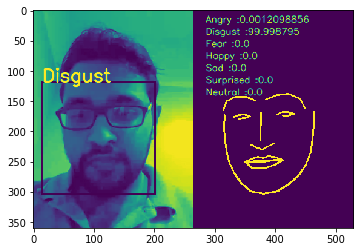

In [26]:
plt.imshow(processed_frames[27])

In [32]:
import zipfile
import pandas as pd
import os
import shutil

In [2]:
with zipfile.ZipFile('/home/ubuntu/videos/facial_expressions-master.zip', 'r') as zip_ref:
    zip_ref.extractall('/home/ubuntu/videos')

In [63]:
df=pd.read_csv('/home/ubuntu/videos/facial_expressions-master/data/legend.csv')
dataset_path='/home/ubuntu/videos/facial_expressions-master/images/'
target_base_path='/home/ubuntu/videos/facial_exp_data/'

In [64]:
emotions=df['emotion'].values
images=df['image'].values
print(emotions,len(emotions))
print(images,len(images))

['anger' 'surprise' 'disgust' ... 'HAPPINESS' 'HAPPINESS' 'HAPPINESS'] 13690
['facial-expressions_2868588k.jpg' 'facial-expressions_2868585k.jpg'
 'facial-expressions_2868584k.jpg' ... 'SharmilaTagore_82.jpg'
 'SharmilaTagore_83.jpg' 'SharmilaTagore_9.jpg'] 13690


In [65]:
def copy_data(source_path,target_path):
    shutil.copy(source_path,target_path)

In [66]:
[copy_data((dataset_path+images[i]),(target_base_path + emotions[i])) for i in range(len(images))]

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

In [87]:
[copy_data((dataset_path+images[i]),(target_base_path + emotions[i])) for i in range(len(images))]


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

In [89]:
t=0
for dirs in ['anger','ANGER','happiness','HAPPINESS','fear','FEAR','neutral','NEUTRAL','disgust','DISGUST','surprise','SURPRISE','sadness','SADNESS','contempt']:
    l=len(os.listdir('/home/ubuntu/videos/facial_exp_data/'+dirs))
    print(l,end= " ")
    t+=l
print()
print("total images: ",t)

228 24 5306 387 13 8 6713 151 13 195 356 12 124 144 9 
total images:  13683


In [74]:
print(len(os.listdir('/home/ubuntu/videos/facial_expressions-master/images/')))

13718


In [86]:
#13690
print(len(df[(df['emotion']=='anger') | (df['emotion']=='ANGER')  ]))
print(len(df[(df['emotion']=='happiness') | (df['emotion']=='HAPPINESS')  ]))
print(len(df[(df['emotion']=='fear') | (df['emotion']=='FEAR')  ]))
print(len(df[(df['emotion']=='neutral') | (df['emotion']=='NEUTRAL')  ]))
print(len(df[(df['emotion']=='disgust') | (df['emotion']=='DISGUST')  ]))
print(len(df[(df['emotion']=='surprise') | (df['emotion']=='SURPRISE')  ]))
print(len(df[(df['emotion']=='sadness') | (df['emotion']=='SADNESS')  ]))
print(len(df[df['emotion']=='contempt']))


252
5696
21
6868
208
368
268
9
